# Computer Vision Assignment 1 Report

## Dataset: Fruits and Vegetables Image Recognition

In this assignment, we aim to implement a Convolutional Neural Network (CNN) to classify images from the "Fruits and Vegetables Image Recognition Dataset." The dataset is available on Kaggle and contains images categorized into multiple classes of fruits and vegetables.

In the following steps, we will:
1. Load and preprocess the dataset.
2. Implement a CNN model for classification.
3. Use both Sigmoid and ReLU activation functions and compare their performance.
4. Initialize the weights using Small Random numbers and Xavier methods and explain the reasoning behind these choices.
5. Apply regularization techniques, such as Dropout and Batch Normalization, to improve generalization.
6. Compare and visualize the results to draw conclusions about the performance of each combination of activation functions and weight initialization techniques.

# Important Notice

Before running the code in this notebook, please ensure the following steps are completed:

1. Create a folder named **`data`** in the root directory of your project.
2. Inside the `data` folder, place the following subfolders:
   - `train` 
   - `test` 
   - `validation` 
3. Install Required Libraries

Make sure you have the following libraries installed. You can install them by running the following command in your terminal:

```bash
pip install torch torchvision matplotlib numpy pandas
```


### 1. Loading and Preprocessing the Dataset

The dataset is loaded using the `torchvision.datasets.ImageFolder` method. This dataset contains images of different fruits and vegetables, organized into folders by class. Each image is first resized to a fixed size of 128x128 pixels, then converted into a PyTorch tensor, and finally normalized to ensure that the input features have consistent scales.

**Steps for Preprocessing**:
- **Resizing**: Resizing all images to the same size of 128x128 pixels ensures uniformity in input dimensions.
- **Normalization**: Each image is normalized to have mean and standard deviation values of 0.5. This centers the data and accelerates model convergence during training.
- **Batching**: The dataset is divided into training, validation, and testing sets, which are loaded into DataLoader objects for efficient minibatch processing during training.


In [18]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def load_data(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = ImageFolder('data/train', transform=transform)
    test_data = ImageFolder('data/test', transform=transform)
    val_data = ImageFolder('data/validation', transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    num_classes = len(train_data.classes)

    return train_loader, test_loader, val_loader, num_classes


### 2. CNN Architecture Implementation, Activation Functions and Regularization Methods

For this task, we chose to implement a Convolutional Neural Network (CNN) with two convolutional layers, each followed by Batch Normalization and MaxPooling. The reasoning for this architecture is as follows:

- **Convolutional Layers**: These are responsible for learning spatial features such as edges, textures, and patterns in the images. The first convolutional layer has 32 filters, and the second has 64 filters, which progressively capture more complex features.
- **Batch Normalization**: After each convolutional layer, Batch Normalization is applied to stabilize the learning process and allow for higher learning rates, preventing overfitting.
- **MaxPooling**: MaxPooling layers reduce the spatial dimensions of the feature maps, effectively reducing the number of parameters while retaining the most important features.
- **Fully Connected Layers**: After flattening the output of the convolutional layers, two fully connected layers are used for classification, with the final layer outputting the number of classes present in the dataset.

This architecture strikes a balance between model complexity and computational efficiency, allowing for efficient training and good performance on image classification tasks.

#### Activation Functions
In this architecture, we tested two activation functions: **ReLU** and **Sigmoid**. 

- **ReLU (Rectified Linear Unit)**: This activation function sets all negative values to zero, which makes it computationally efficient. ReLU helps to avoid the vanishing gradient problem, making it suitable for deep networks.
  
- **Sigmoid**: Sigmoid squashes the input to a range between 0 and 1, which can be useful in specific applications like binary classification. However, it suffers from the vanishing gradient problem, which can slow down training in deep networks.

For the hidden layers in this model, **ReLU** is generally a better choice because it allows for faster convergence and better gradient flow.

#### Regularization Methods
To prevent overfitting, I applied two regularization techniques in the CNN model:

- **Dropout**: Dropout randomly turns off a fraction of neurons during training, which forces the model to learn more robust features and prevents it from memorizing the training data.
  
- **Batch Normalization**: This technique normalizes the output of the previous layer, stabilizing the training process and allowing for higher learning rates. It also acts as a regularizer by reducing the dependency on specific weights.

In [3]:
import torch.nn as nn
import torch

class CNNModel(nn.Module):
    def __init__(self, num_classes, activation_fn='relu'):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Set activation function
        if activation_fn == 'relu':
            self.activation = nn.functional.relu
        elif activation_fn == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### 3. Weight Initialization Methods

Weight initialization plays a crucial role in the convergence of the model. I implemented two weight initialization methods:

- **Small Random Numbers**: This method initializes the weights with small random values from a normal distribution. It ensures that the model starts with small weights, preventing large gradients at the start of training.
  
- **Xavier Initialization**: Xavier initialization scales the weights based on the number of input and output units for each layer. It helps maintain the variance of gradients during backpropagation, preventing the exploding or vanishing gradient problems, which are common in deeper networks.

Xavier initialization is typically preferred for models with non-linear activation functions, as it leads to better convergence.


In [4]:
def weights_init_small(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)

def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

### 4. Training the CNN Model

The model is trained using the **train.py** script, which trains the CNN with different combinations of activation functions (ReLU, Sigmoid) and weight initialization methods (Small Random Numbers, Xavier). The key steps involved in training are:

1. **Loss Function**: The cross-entropy loss function (`nn.CrossEntropyLoss`) is used since this is a multi-class classification problem.
2. **Optimizer**: The Adam optimizer (`optim.Adam`) is employed to minimize the loss function and update the model weights.
3. **Training Loop**: The model is trained over 10 epochs. For each epoch, the training loss is recorded, and after each epoch, the model's performance is evaluated on the validation set to track validation accuracy.
4. **Weight Initialization**: At the start of training, weights are initialized using either the Small Random Numbers method or the Xavier method.
5. **Saving Model and Metrics**: After each training run, the model's state is saved to disk as a `.pth` file, and the training loss and validation accuracy are stored in a JSON file for later analysis.

The training script ensures that we can easily compare different configurations of activation functions and weight initialization methods.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import json
import os


def weights_init_small(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)

def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def train_model(activation='relu', init_method='xavier'):
    # Loading data
    train_loader, test_loader, val_loader, num_classes = load_data()

    # Creating a model with a dynamic number of classes
    model = CNNModel(num_classes)

    # Initializing weights
    if init_method == 'small_random':
        model.apply(weights_init_small)
    elif init_method == 'xavier':
        model.apply(weights_init_xavier)

    # Setting the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Training the model
    num_epochs = 10
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Evaluation on the validation set
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        print(f'Validation Accuracy: {accuracy}%')

    # Creating a folder to save models if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Saving the model
    model_save_path = f'models/model_cnn_{activation}_{init_method}.pth'
    torch.save(model.state_dict(), model_save_path)

    # Creating a folder to save metrics if it doesn't exist
    if not os.path.exists('results'):
        os.makedirs('results')

    # Saving loss and accuracy data to a file
    metrics_save_path = f'results/train_val_metrics_{activation}_{init_method}.json'
    with open(metrics_save_path, 'w') as f:
        json.dump({'train_losses': train_losses, 'val_accuracies': val_accuracies}, f)

# Training with different combinations of activation and initialization
train_model(activation='relu', init_method='small_random')
train_model(activation='relu', init_method='xavier')
train_model(activation='sigmoid', init_method='small_random')
train_model(activation='sigmoid', init_method='xavier')


### 5. Evaluating the CNN Model

The **evaluate.py** script is responsible for testing the trained models on the test dataset. It loads each trained model (which was saved during the training process) and computes the test accuracy.

Key aspects of the evaluation process:
- **Loading Trained Models**: The saved models are loaded using `torch.load()`.
- **Test Accuracy**: For each model, predictions are made on the test set, and the test accuracy is computed by comparing the predicted labels with the true labels.
- **Multiple Configurations**: The evaluation script runs the test for all combinations of activation functions and weight initialization methods.

The results give us a better understanding of how well each configuration performs on unseen data.


In [20]:
import torch
import torch.nn as nn
    
def evaluate(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Loading data
_, test_loader, _, num_classes = load_data()

# List of all activation and initialization combinations
combinations = [
    ('relu', 'small_random'),
    ('relu', 'xavier'),
    ('sigmoid', 'small_random'),
    ('sigmoid', 'xavier')
]

# Evaluate each combination
for activation_fn, init_method in combinations:
    model_save_path = f'models/model_cnn_{activation_fn}_{init_method}.pth'
    
    try:
        # Creating model with selected activation
        model = CNNModel(num_classes, activation_fn=activation_fn)
        model.load_state_dict(torch.load(model_save_path))
        model.eval()

        # Evaluate the model
        accuracy = evaluate(model, test_loader)
        print(f'Test Accuracy for {activation_fn} + {init_method}: {accuracy}%')
    
    except FileNotFoundError:
        print(f"Model file not found for {activation_fn} + {init_method}: {model_save_path}")


C:\Users\Dias\AppData\Local\Temp\ipykernel_19056\447257685.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Accuracy for relu + small_random: 85.23676880222841%
Test Accuracy for relu + xavier: 92.47910863509749%
Test Accuracy for sigmoid + small_random: 2.785515320334262%
Test Accuracy for sigmoid + xavier: 8.635097493036211%


### 6. Results Comparison and Visualization

To evaluate the model's performance, we compared the training loss and validation accuracy for different combinations of activation functions (ReLU and Sigmoid) and weight initialization methods (Small Random Numbers and Xavier).

By visualizing the results, we can understand how each combination affects the training process, model accuracy, and convergence. The following graphs show the results for each combination.


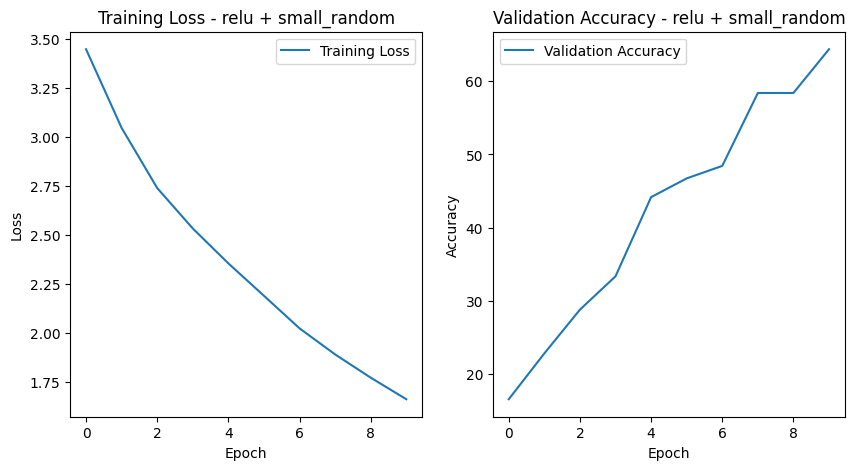

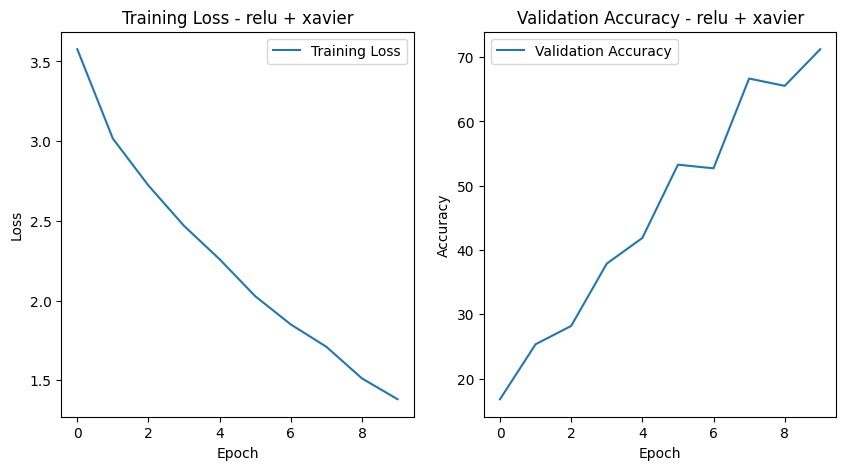

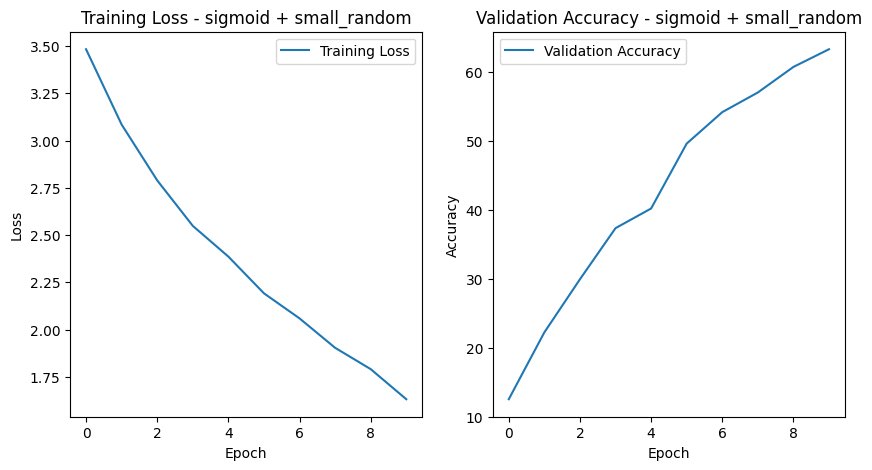

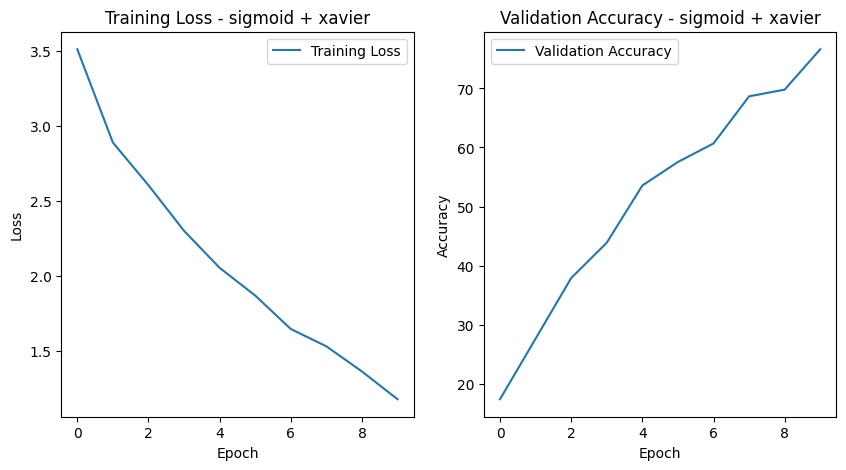

In [19]:
import matplotlib.pyplot as plt
import json

def plot_loss_accuracy(train_losses, val_accuracies, title_suffix):
    plt.figure(figsize=(10, 5))

    # Plotting training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title(f'Training Loss - {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Validation Accuracy - {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# All combinations of activations and initialization methods
combinations = [
    ('relu', 'small_random'),
    ('relu', 'xavier'),
    ('sigmoid', 'small_random'),
    ('sigmoid', 'xavier')
]

# Visualization for each combination
for activation_fn, init_method in combinations:
    try:
        metrics_file = f'results/train_val_metrics_{activation_fn}_{init_method}.json'
        
        # Loading metrics
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)

        train_losses = metrics['train_losses']
        val_accuracies = metrics['val_accuracies']

        # Visualizing losses and accuracies for each combination
        plot_loss_accuracy(train_losses, val_accuracies, f'{activation_fn} + {init_method}')
    
    except FileNotFoundError:
        print(f"Metrics file not found for {activation_fn} + {init_method}: {metrics_file}")


### 7. Results Evaluation and Analysis

After visualizing the training and validation performance for each combination, and evaluating the test accuracy using the **evaluate.py** script, we can compare the results.

#### Observations:
- **ReLU vs. Sigmoid**: In most cases, models with ReLU activation performed better, both in terms of validation accuracy and test accuracy. This is likely due to the fact that ReLU avoids the vanishing gradient problem, which is common with Sigmoid in deeper networks.
- **Xavier Initialization**: Models initialized using the Xavier method converged faster and reached higher accuracy compared to the models initialized with Small Random Numbers. This confirms that Xavier initialization is more suitable for deeper networks with non-linear activation functions.
- **Regularization**: The use of Dropout and Batch Normalization effectively prevented overfitting, as indicated by the relatively high validation and test accuracy for most models.


